In [1]:
import numpy as np
import torch
import pyepo

# random seed
np.random.seed(42)
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
grid = (5,5) # grid size
num_data = 1000 # number of training data
num_feat = 5 # size of feature
deg = 4 # polynomial degree
e = 0 # noise width
feats, costs = pyepo.data.shortestpath.genData(num_data+1000, num_feat, grid, deg, e, seed=42)

In [3]:
from pyepo.model.grb import shortestPathModel
# set solver
optmodel = shortestPathModel(grid)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
for i, e in enumerate(optmodel.arcs):
    if sol[i] > 1e-3:
        print(e)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-01
Obj: 4.5703345390527765
(0, 5)
(5, 6)
(6, 11)
(11, 12)
(12, 17)
(17, 18)
(18, 19)
(19, 24)


In [4]:
# split data
from sklearn.model_selection import train_test_split
x_train, x_test, c_train, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)

In [5]:
from dataset import optDatasetConstrs
# get training and test data set
dataset_train_cost = pyepo.data.dataset.optDataset(optmodel, x_train, costs=c_train)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test) # without binding constr

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 738.25it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 712.12it/s]


In [6]:
# get training and test data set without costs
dataset_train = optDatasetConstrs(optmodel, x_train, sols=dataset_train_cost.sols) # with binding constr

Obtaining constraints for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 632.05it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, (grid[0]-1)*grid[1]+(grid[1]-1)*grid[0])

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt
def plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Loss Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    fig = plt.figure(figsize=(16, 8))
    plt.plot([i * log_step for i in range(len(regret_log_trn))], regret_log_trn,
             color="royalblue", ls="--", alpha=0.7, lw=5, label="Train")
    plt.plot([i * log_step for i in range(len(regret_log_val))], regret_log_val,
             color="lightcoral", ls=":", alpha=0.7, lw=5, label="Val")
    plt.xlim(-1, num_epochs+1)
    plt.ylim(0, 0.8)
    plt.xticks(range(0, num_epochs+1, 5), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.legend(fontsize=32)
    plt.title("Regret Curve on Training and Validation Set", fontsize=36)
    plt.show()

## Train

In [10]:
import time

def train(reg, loss_func, lr, num_epochs, log_step):
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # init log
    loss_log = []
    regret_log_trn = [pyepo.metric.regret(reg, optmodel, loader_train_cost)]
    regret_log_val = [pyepo.metric.regret(reg, optmodel, loader_test)]
    # running time
    elapsed = 0
    for epoch in range(num_epochs):
        tick = time.time()
        for data in loader_train:
            x, w, t_ctr = data
            # forward pass
            cp = reg(x)
            loss = loss_func(cp, t_ctr)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_log.append(loss.item())
        # record time
        tock = time.time()
        elapsed += tock - tick
        if (epoch+1) % log_step == 1:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_log_trn.append(regret_trn)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_test)
            regret_log_val.append(regret_val)
            print("Epoch {:3}, Loss: {:8.4f}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                  format(epoch, loss.item(), regret_trn*100, regret_val*100))
    print("Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, regret_log_trn, regret_log_val

### Exact Method 

In [11]:
# init model
reg = LinearRegression()

In [12]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel)

In [13]:
lr = 5e-3
num_epochs = 20
log_step = 2
loss_log, regret_log_trn, regret_log_val = train(reg, ca_cos, lr, num_epochs, log_step)

Epoch   0, Loss:  -0.9845, Train Regret:  28.7568%, Val Regret:  28.8718%
Epoch   2, Loss:  -0.9961, Train Regret:  11.8329%, Val Regret:  12.1822%
Epoch   4, Loss:  -0.9998, Train Regret:   4.7673%, Val Regret:   6.1402%
Epoch   6, Loss:  -1.0000, Train Regret:   3.2805%, Val Regret:   3.8208%
Epoch   8, Loss:  -0.9999, Train Regret:   2.4245%, Val Regret:   3.1124%
Epoch  10, Loss:  -0.9999, Train Regret:   2.0263%, Val Regret:   2.7903%
Epoch  12, Loss:  -0.9999, Train Regret:   1.7007%, Val Regret:   2.3645%
Epoch  14, Loss:  -1.0000, Train Regret:   1.5180%, Val Regret:   1.9759%
Epoch  16, Loss:  -0.9999, Train Regret:   1.3798%, Val Regret:   1.7896%
Epoch  18, Loss:  -1.0000, Train Regret:   1.2593%, Val Regret:   1.5707%
Elapsed Time: 132.36 Sec


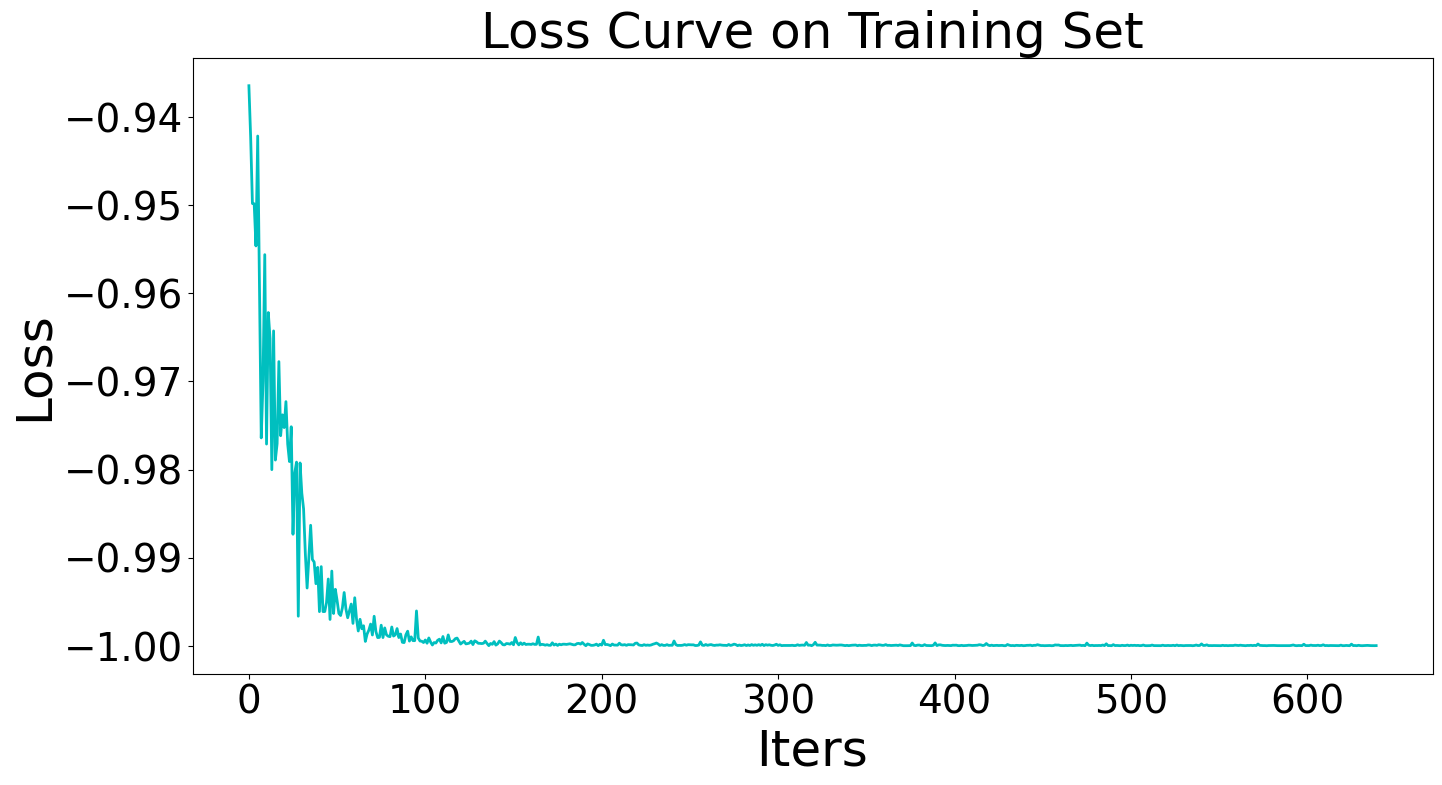

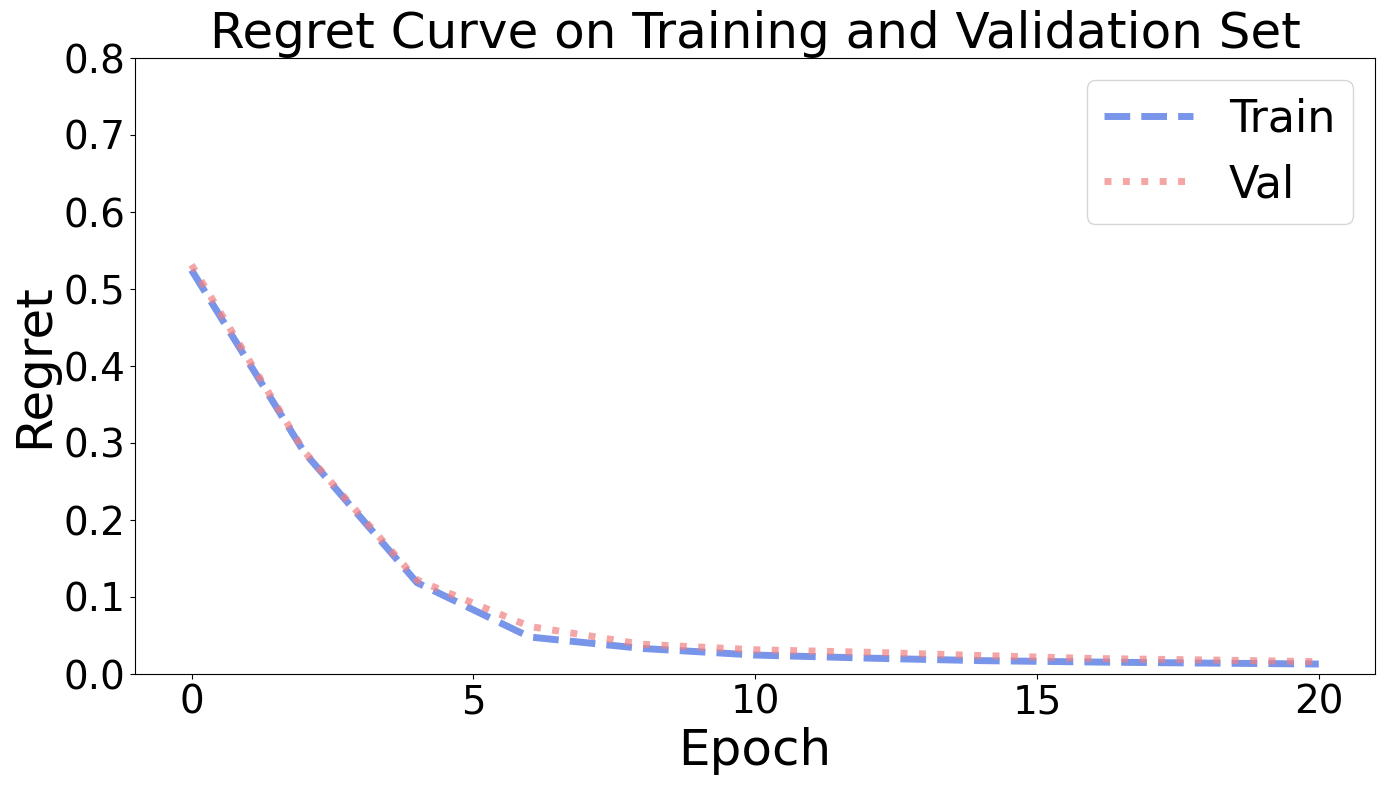

In [14]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

###  Base Vector Method

In [15]:
# init model
reg = LinearRegression()

In [16]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F

from pyepo import EPO
from pyepo.model.opt import optModel

from func import abstractConeAlignedCosine

class baseVectConeAlignedCosine(abstractConeAlignedCosine):
    """
    A autograd module to align cone and vector cosine similarity loss via base vectors
    """
    def _calLoss(self, pred_cost, tight_ctrs, optmodel):
        """
        A method to calculate loss
        """
        # get device
        device = pred_cost.device
        # get batch size
        batch_size = len(pred_cost)
        # init loss
        loss = torch.empty(batch_size).to(device)
        # cost vectors direction
        if optmodel.modelSense == EPO.MINIMIZE:
            # minimize
            pred_cost = - pred_cost
        # calculate cosine similarity
        cos_sim = F.cosine_similarity(pred_cost.unsqueeze(1), tight_ctrs, dim=2)
        # get max cosine similarity for each sample
        max_cos_sim, _ = torch.max(cos_sim, dim=1)
        loss = - max_cos_sim
        return loss

# init loss
ca_cos = baseVectConeAlignedCosine(optmodel)

In [17]:
lr = 5e-3
num_epochs = 20
log_step = 2
loss_log, regret_log_trn, regret_log_val = train(reg, ca_cos, lr, num_epochs, log_step)

Epoch   0, Loss:  -0.4922, Train Regret:  45.5146%, Val Regret:  45.1065%
Epoch   2, Loss:  -0.7541, Train Regret:  49.2739%, Val Regret:  48.9740%
Epoch   4, Loss:  -0.7810, Train Regret:  59.7554%, Val Regret:  58.4864%
Epoch   6, Loss:  -0.8228, Train Regret:  57.7747%, Val Regret:  57.0030%
Epoch   8, Loss:  -0.9136, Train Regret:  50.4263%, Val Regret:  51.6847%
Epoch  10, Loss:  -0.9471, Train Regret:  52.6030%, Val Regret:  51.8935%
Epoch  12, Loss:  -0.9469, Train Regret:  44.3212%, Val Regret:  44.3928%
Epoch  14, Loss:  -0.9827, Train Regret:  61.0455%, Val Regret:  61.1557%
Epoch  16, Loss:  -0.9879, Train Regret:  37.6745%, Val Regret:  37.7308%
Epoch  18, Loss:  -0.9982, Train Regret:  49.9542%, Val Regret:  48.8114%
Elapsed Time: 1.46 Sec


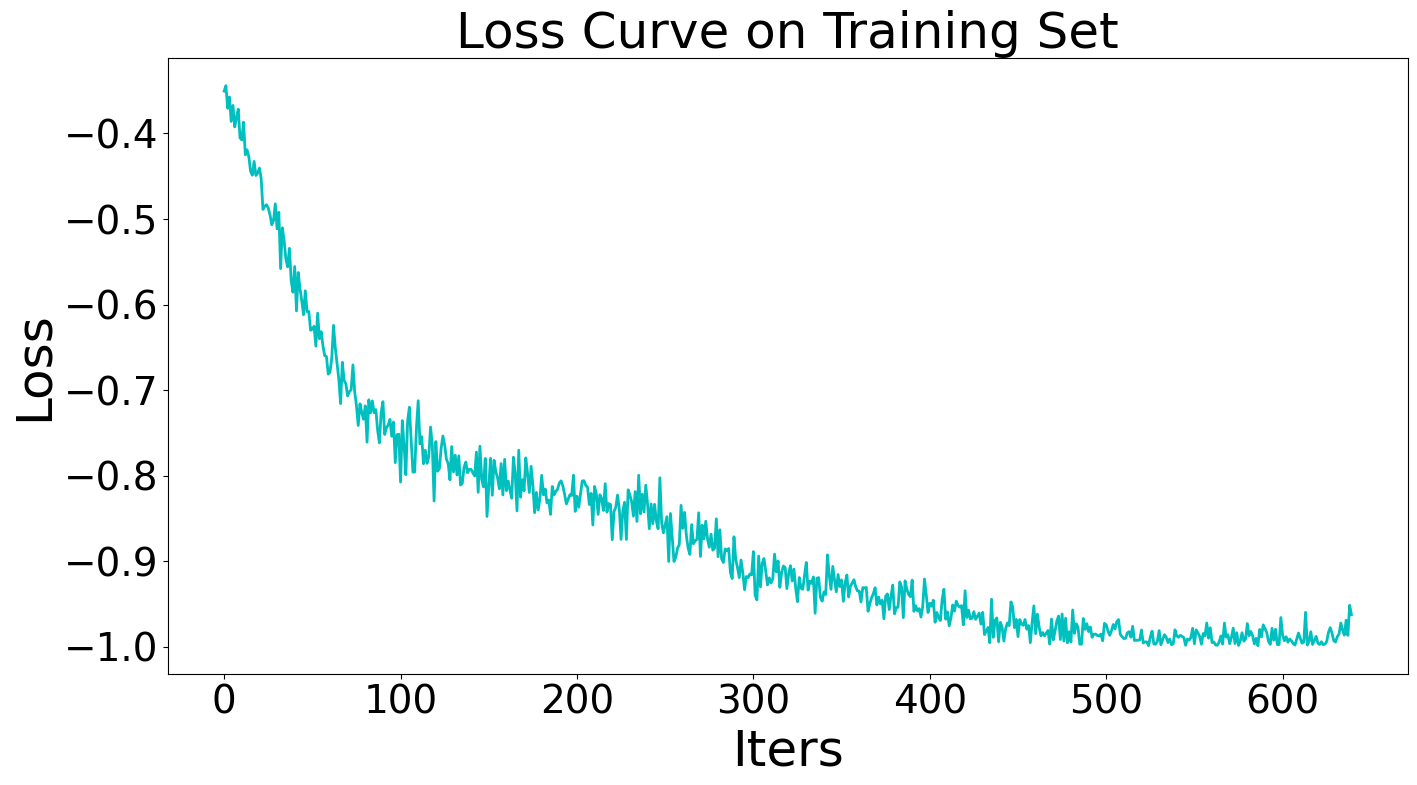

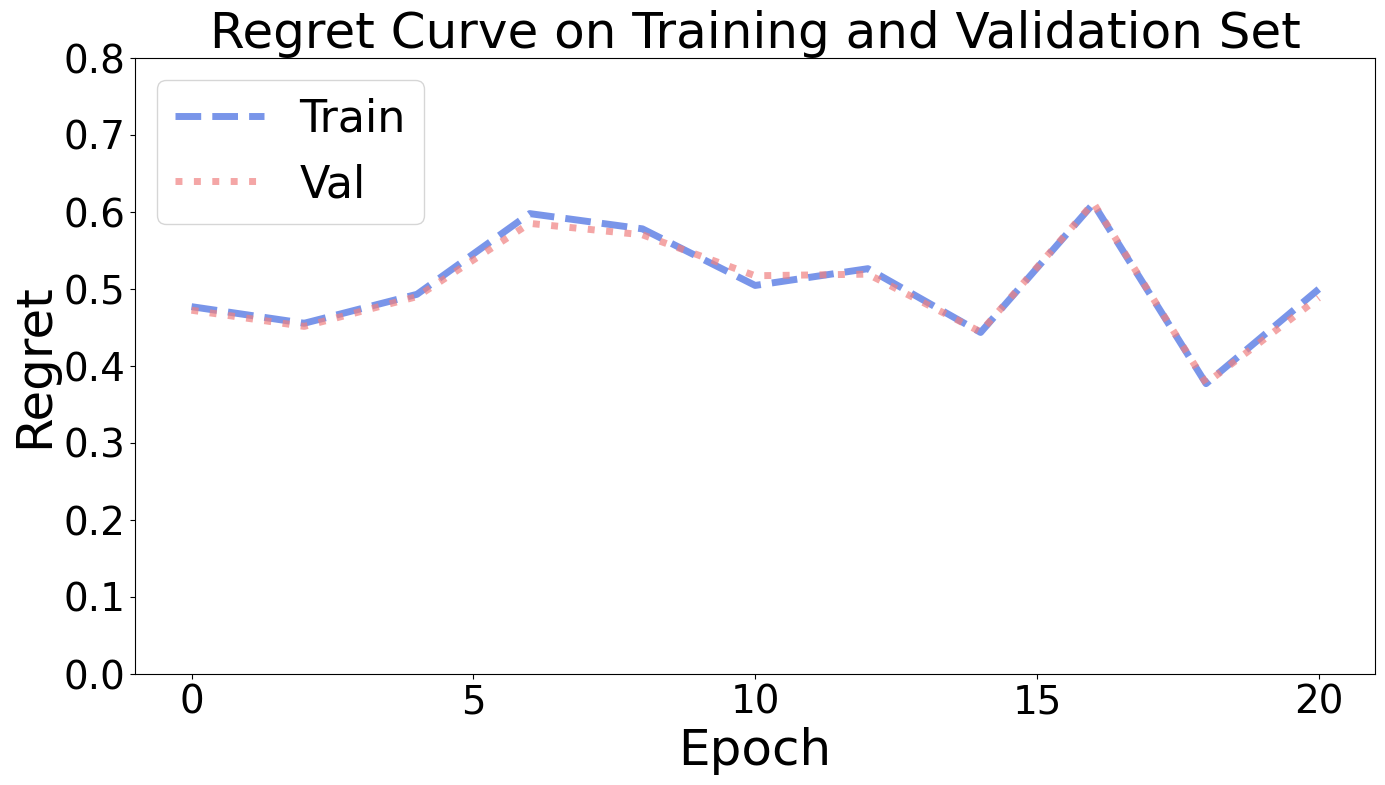

In [18]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

###  Average Vector Method

In [19]:
# init model
reg = LinearRegression()

In [20]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F

from pyepo import EPO
from pyepo.model.opt import optModel

from func import abstractConeAlignedCosine

class avgVectConeAlignedCosine(abstractConeAlignedCosine):
    """
    A autograd module to align cone and vector cosine similarity loss via average base vectors
    """
    def _calLoss(self, pred_cost, tight_ctrs, optmodel):
        """
        A method to calculate loss
        """
        # get device
        device = pred_cost.device
        # get batch size
        batch_size = len(pred_cost)
        # init loss
        loss = torch.empty(batch_size).to(device)
        # cost vectors direction
        if optmodel.modelSense == EPO.MINIMIZE:
            # minimize
            pred_cost = - pred_cost
        # calculate cosine similarity
        cos_sim = F.cosine_similarity(pred_cost.unsqueeze(1),
                                      tight_ctrs.mean(axis=0).unsqueeze(0),
                                      dim=2)
        # get max cosine similarity for each sample
        loss = - cos_sim
        return loss

# init loss
ca_cos = avgVectConeAlignedCosine(optmodel)

In [21]:
lr = 5e-3
num_epochs = 20
log_step = 2
loss_log, regret_log_trn, regret_log_val = train(reg, ca_cos, lr, num_epochs, log_step)

Epoch   0, Loss:  -0.0193, Train Regret:  51.9544%, Val Regret:  52.1310%
Epoch   2, Loss:  -0.0460, Train Regret:  46.6435%, Val Regret:  45.9304%
Epoch   4, Loss:  -0.0666, Train Regret:  45.3485%, Val Regret:  44.7417%
Epoch   6, Loss:  -0.0622, Train Regret:  49.3503%, Val Regret:  50.0418%
Epoch   8, Loss:  -0.0625, Train Regret:  38.9123%, Val Regret:  38.5591%
Epoch  10, Loss:  -0.0558, Train Regret:  45.2265%, Val Regret:  43.4622%
Epoch  12, Loss:  -0.0661, Train Regret:  41.2399%, Val Regret:  41.2130%
Epoch  14, Loss:  -0.0552, Train Regret:  38.2209%, Val Regret:  38.2889%
Epoch  16, Loss:  -0.0607, Train Regret:  33.0670%, Val Regret:  32.1825%
Epoch  18, Loss:  -0.0578, Train Regret:  35.9489%, Val Regret:  34.8848%
Elapsed Time: 1.38 Sec


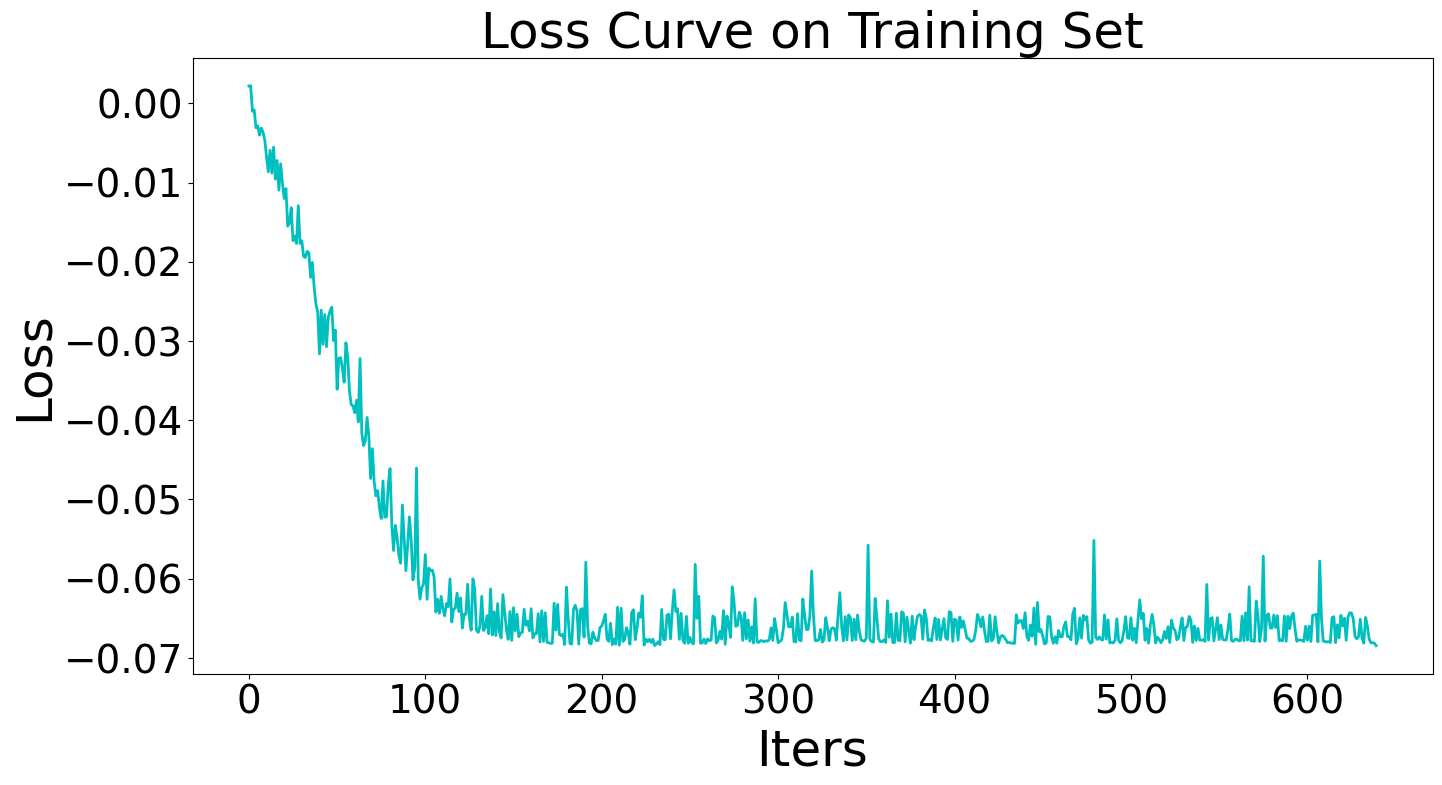

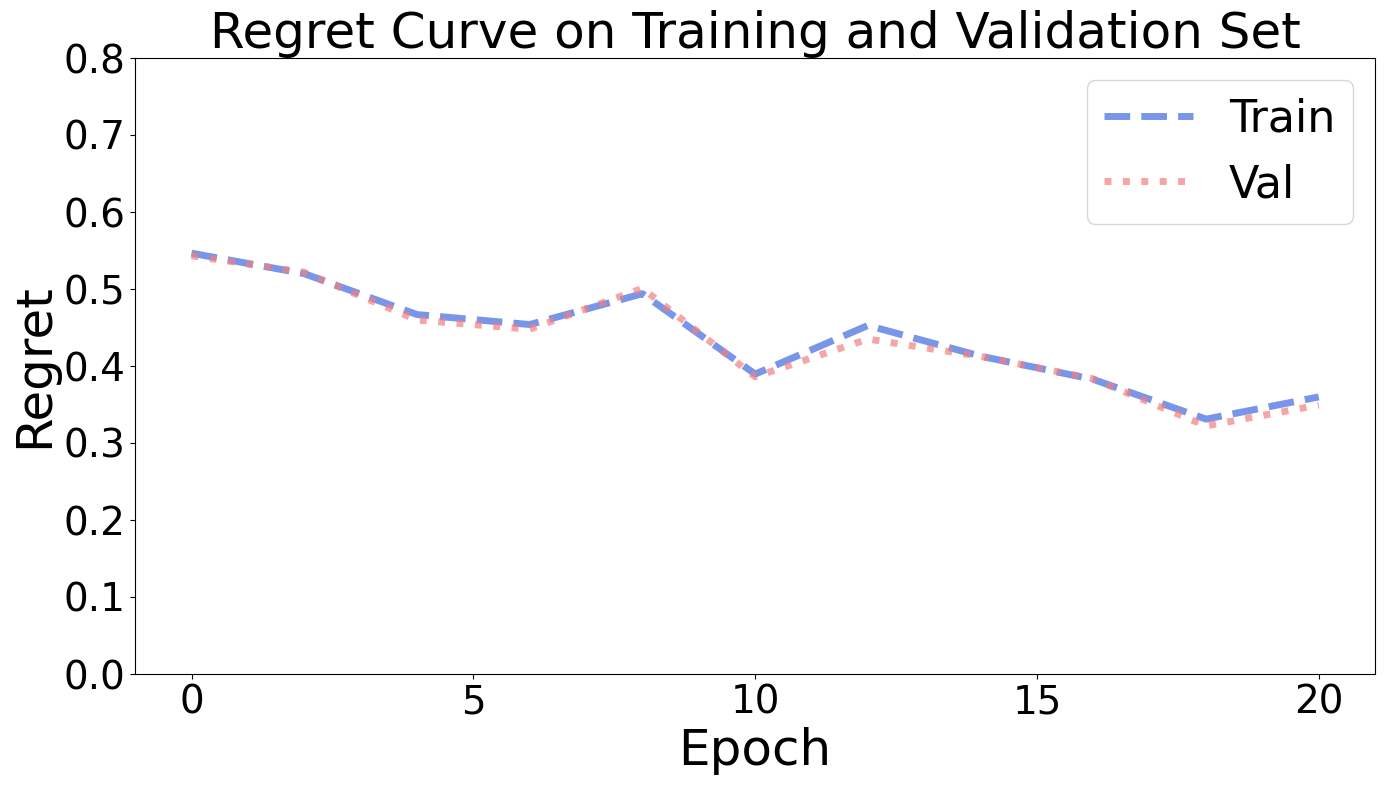

In [22]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sampling Method

In [23]:
# init model
reg = LinearRegression()

In [24]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100)

In [25]:
lr = 5e-3
num_epochs = 20
log_step = 2
loss_log, regret_log_trn, regret_log_val = train(reg, ca_cos, lr, num_epochs, log_step)

Epoch   0, Loss:  -0.4312, Train Regret:  29.1016%, Val Regret:  29.7081%
Epoch   2, Loss:  -0.6258, Train Regret:   4.8801%, Val Regret:   5.4828%
Epoch   4, Loss:  -0.6837, Train Regret:   2.3982%, Val Regret:   3.0760%
Epoch   6, Loss:  -0.6818, Train Regret:   2.3755%, Val Regret:   2.9414%
Epoch   8, Loss:  -0.6847, Train Regret:   2.3646%, Val Regret:   2.7071%
Epoch  10, Loss:  -0.7120, Train Regret:   2.2953%, Val Regret:   2.5907%
Epoch  12, Loss:  -0.7121, Train Regret:   2.4636%, Val Regret:   2.9661%
Epoch  14, Loss:  -0.6668, Train Regret:   2.4069%, Val Regret:   3.0829%
Epoch  16, Loss:  -0.6947, Train Regret:   2.6704%, Val Regret:   3.2723%
Epoch  18, Loss:  -0.6924, Train Regret:   2.2837%, Val Regret:   2.8266%
Elapsed Time: 5.02 Sec


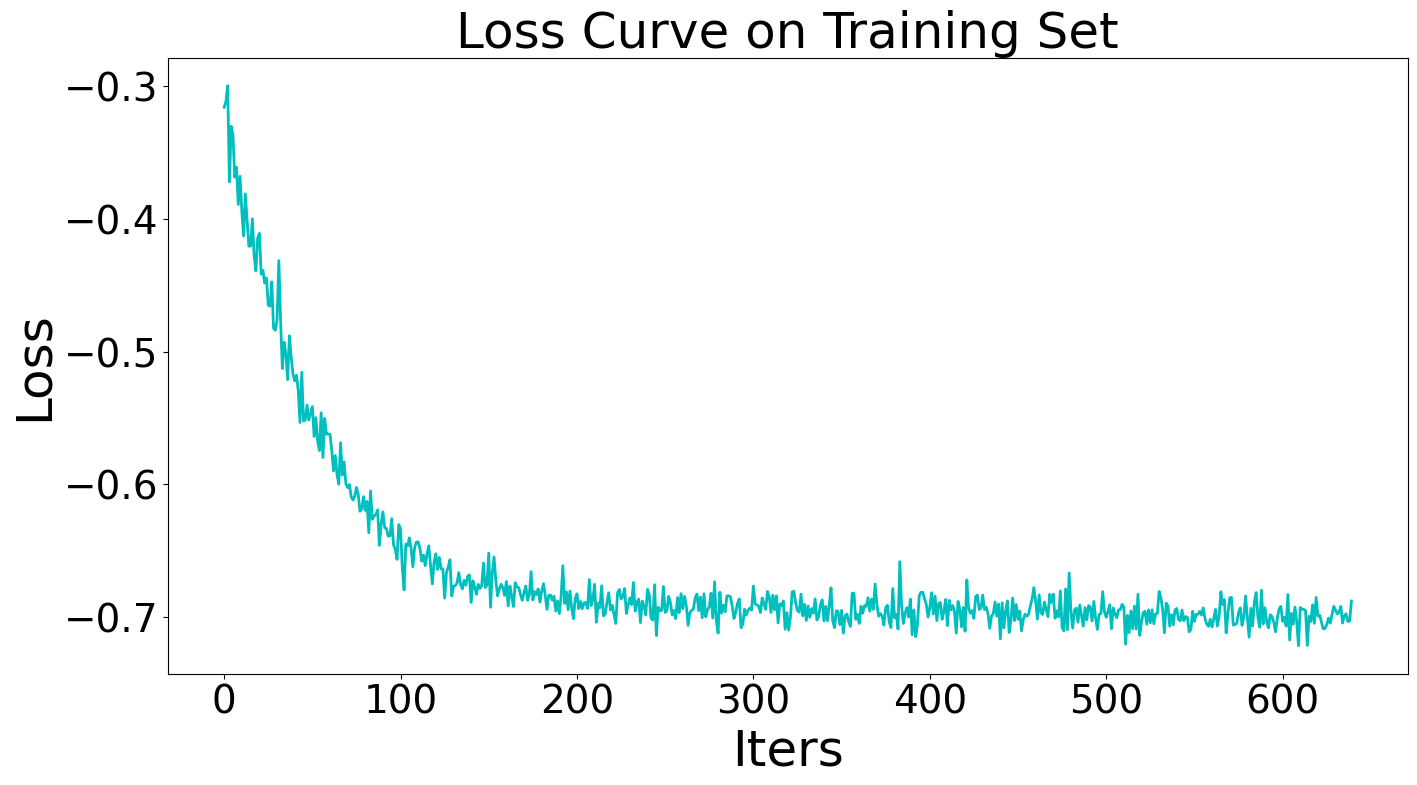

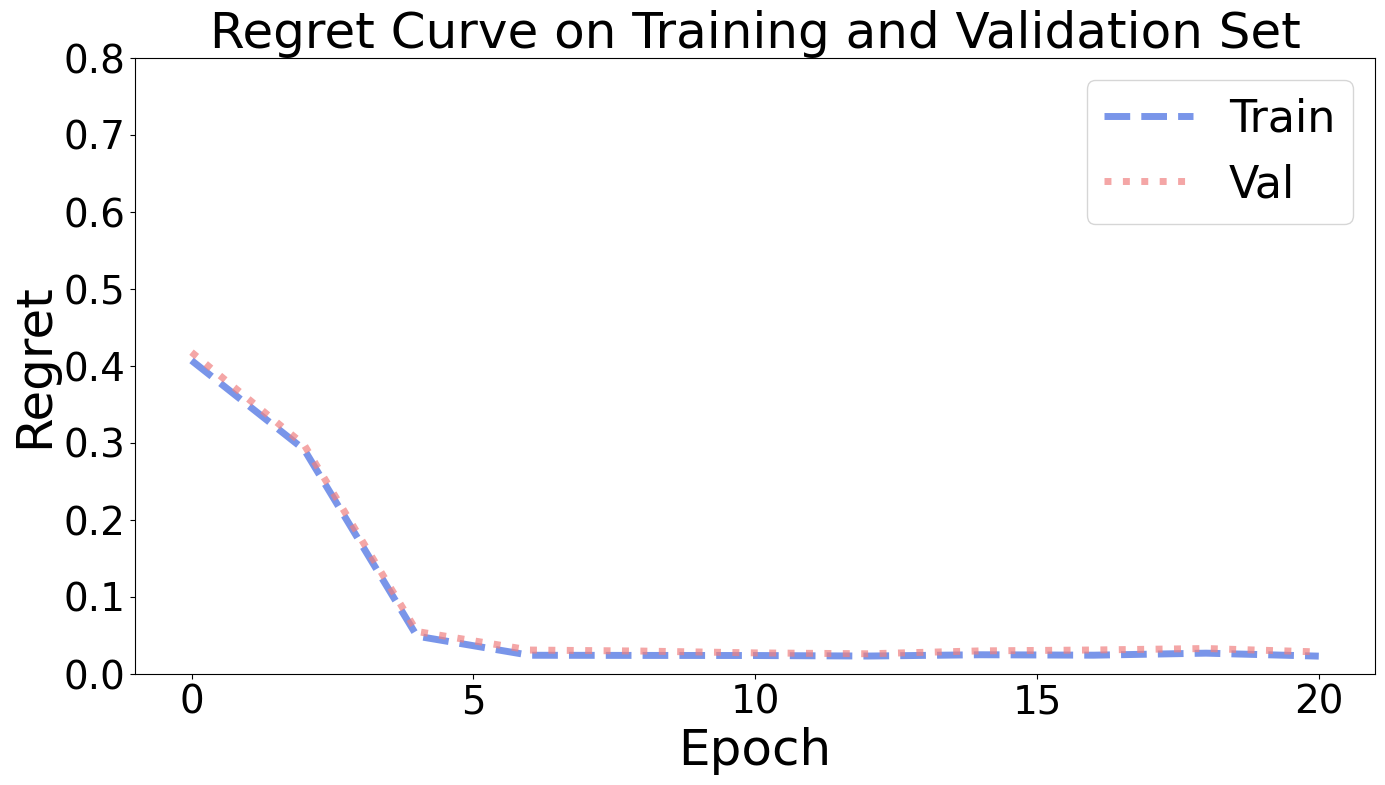

In [26]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sign Method

In [27]:
# init model
reg = LinearRegression()

In [28]:
from func import signConeAlignedCosine
# init loss
ca_cos = signConeAlignedCosine(optmodel)

In [29]:
lr = 5e-3
num_epochs = 20
log_step = 2
loss_log, regret_log_trn, regret_log_val = train(reg, ca_cos, lr, num_epochs, log_step)

Epoch   0, Loss:  -0.8850, Train Regret:  23.8452%, Val Regret:  22.6663%
Epoch   2, Loss:  -0.9850, Train Regret:   7.0053%, Val Regret:   8.4724%
Epoch   4, Loss:  -0.9893, Train Regret:   4.0035%, Val Regret:   4.6224%
Epoch   6, Loss:  -0.9805, Train Regret:   3.5126%, Val Regret:   4.0818%
Epoch   8, Loss:  -0.9966, Train Regret:   3.4346%, Val Regret:   3.9824%
Epoch  10, Loss:  -0.9933, Train Regret:   3.3213%, Val Regret:   3.9685%
Epoch  12, Loss:  -0.9918, Train Regret:   3.4122%, Val Regret:   4.2086%
Epoch  14, Loss:  -0.9962, Train Regret:   3.5628%, Val Regret:   4.1315%
Epoch  16, Loss:  -0.9944, Train Regret:   3.6511%, Val Regret:   4.1455%
Epoch  18, Loss:  -0.9980, Train Regret:   3.5666%, Val Regret:   4.1852%
Elapsed Time: 6.04 Sec


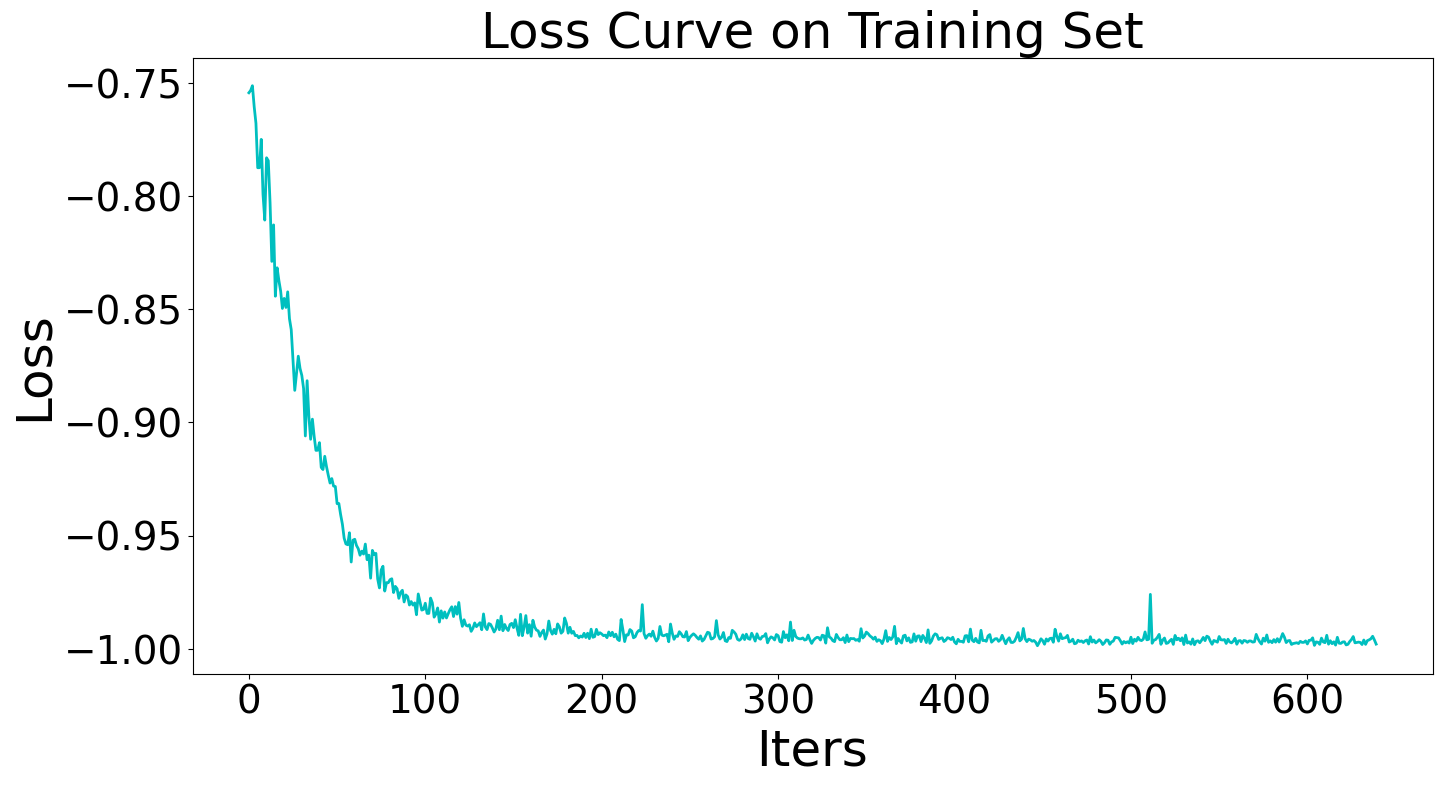

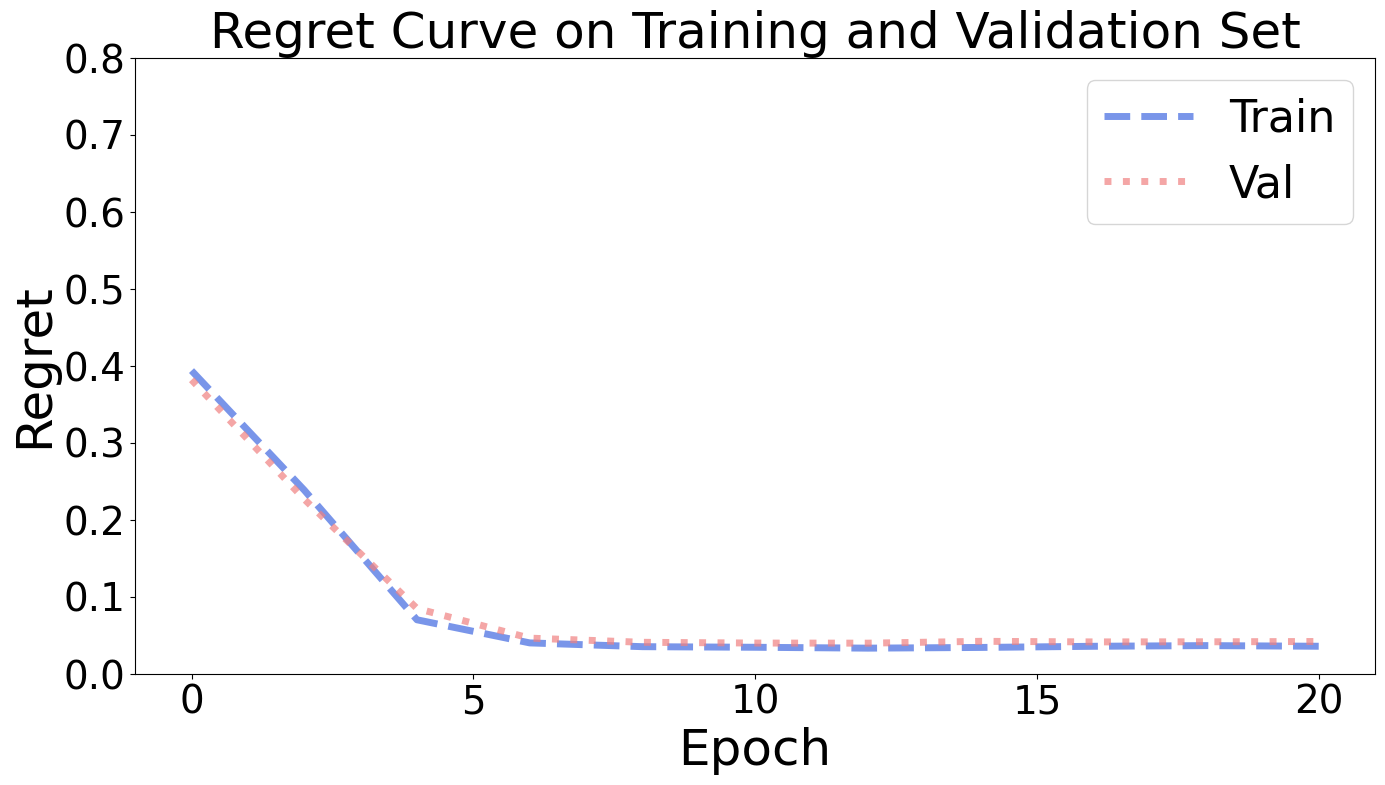

In [30]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)